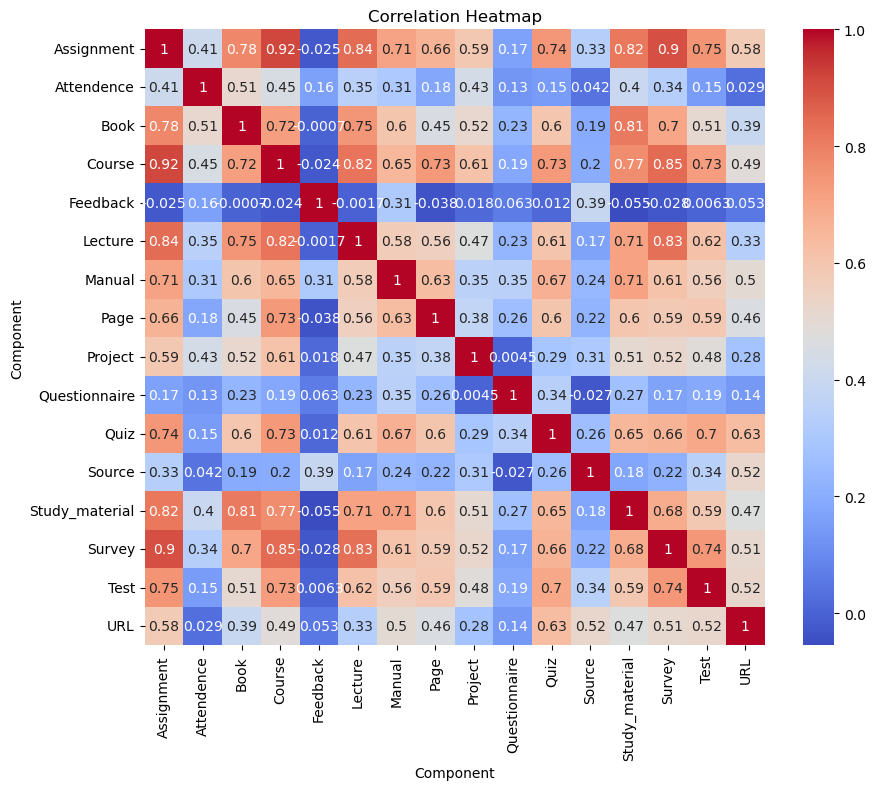

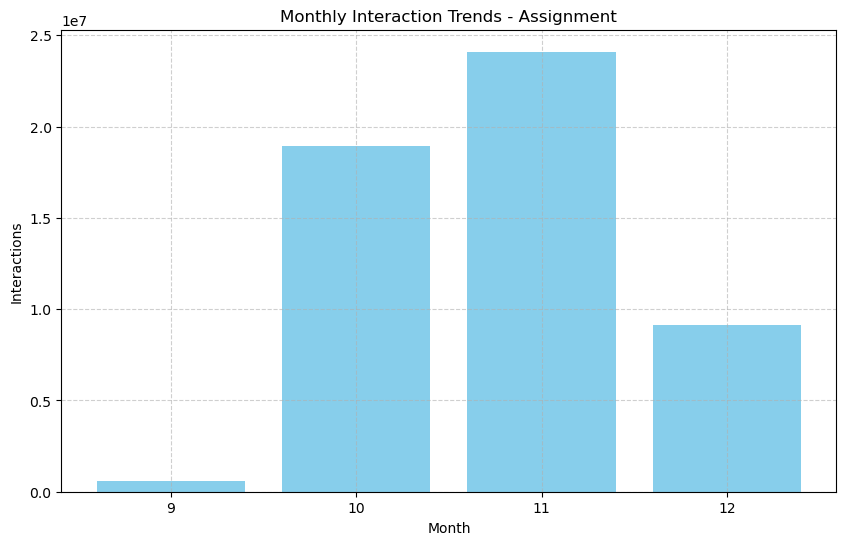

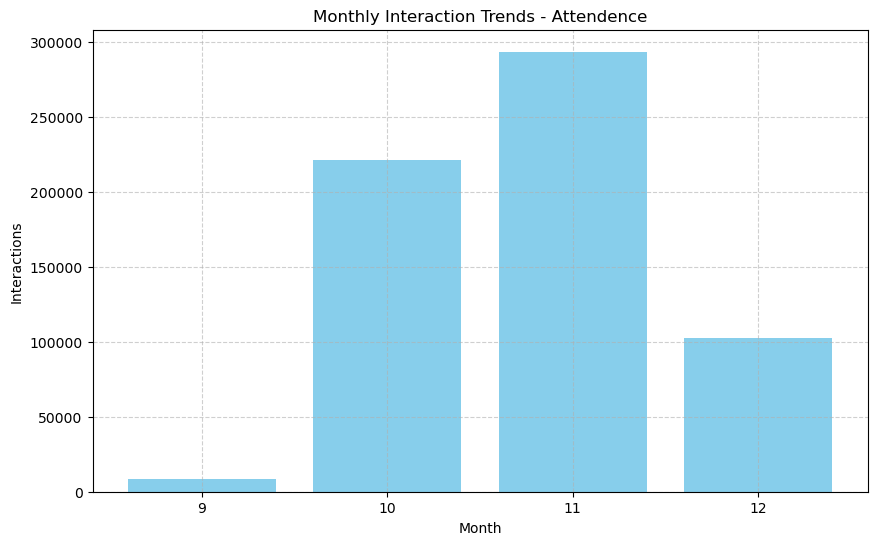

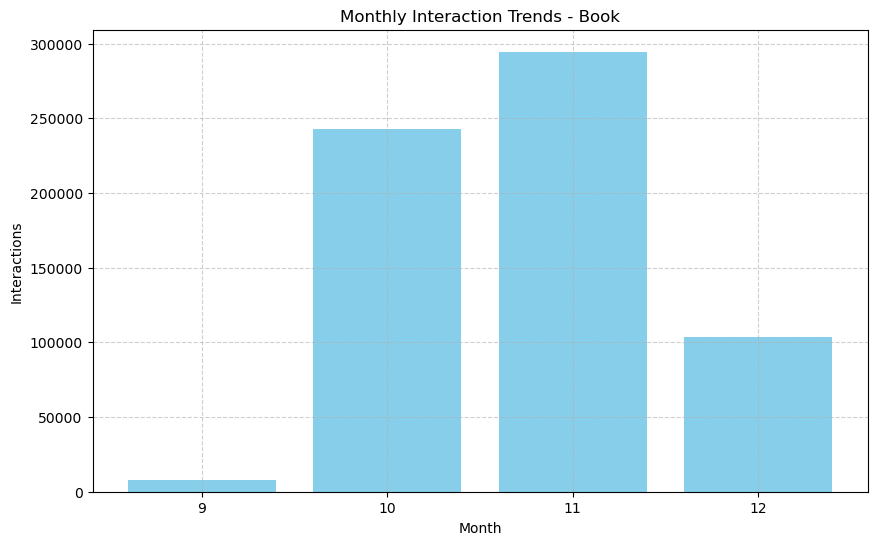

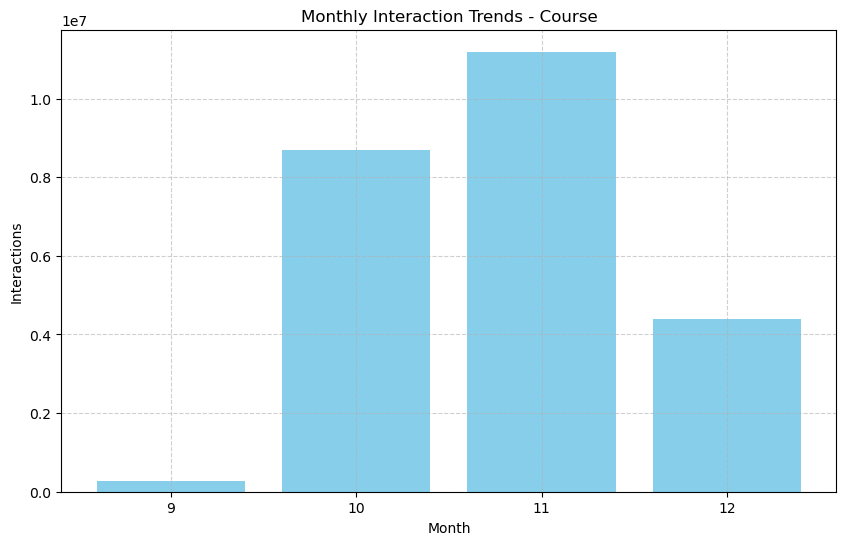

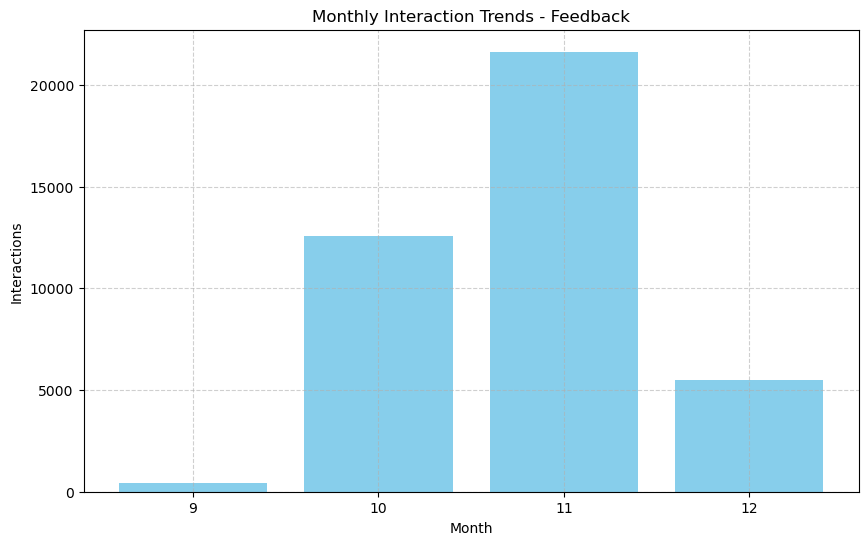

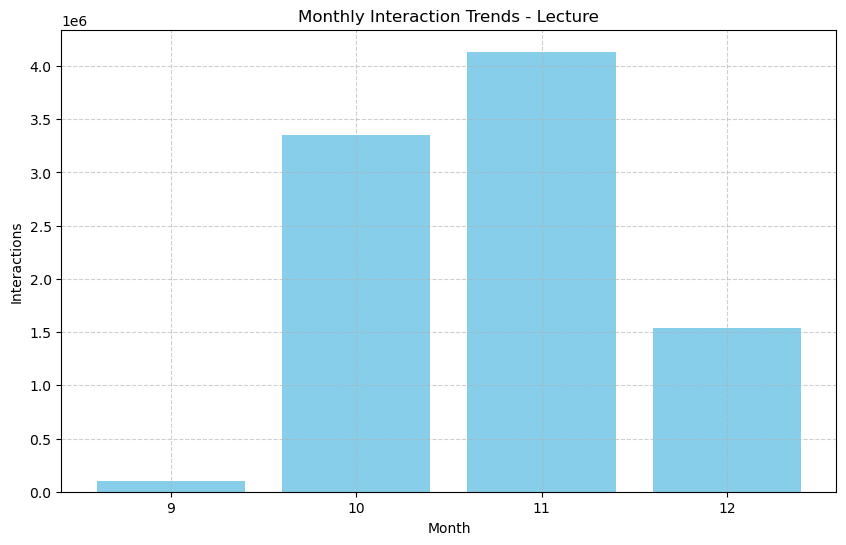

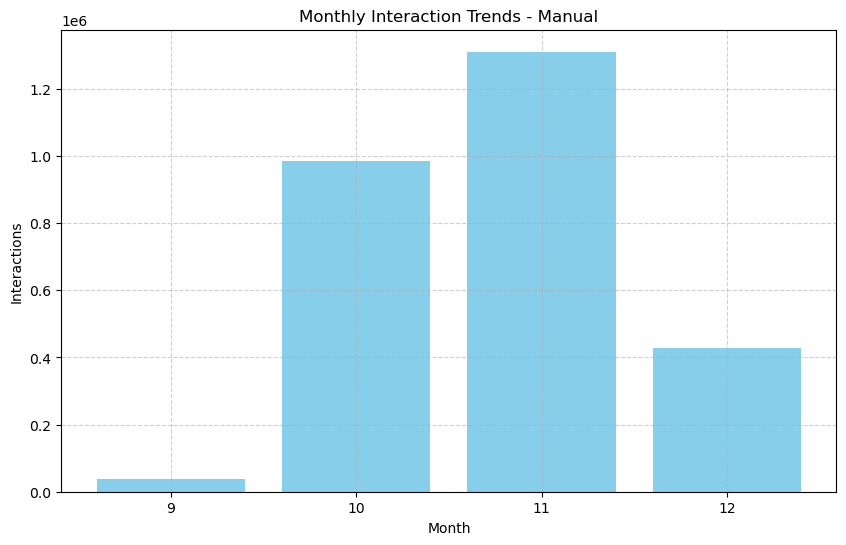

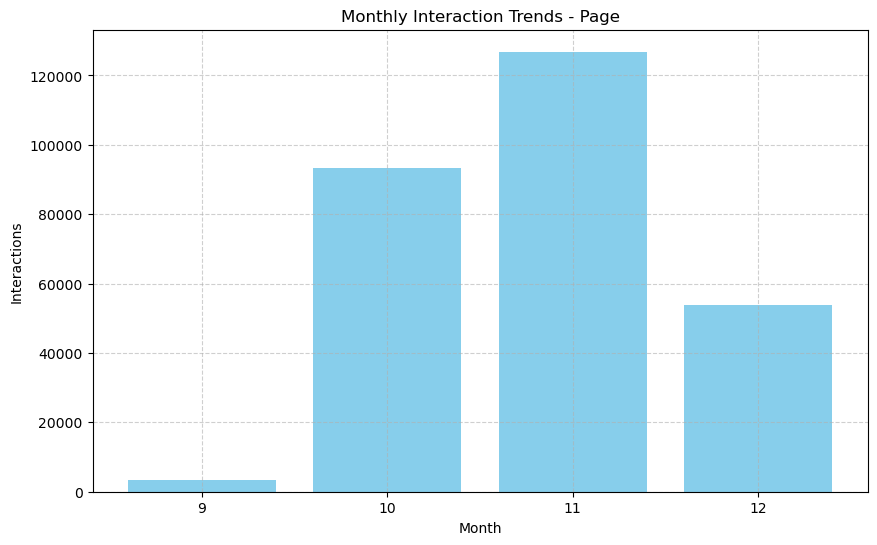

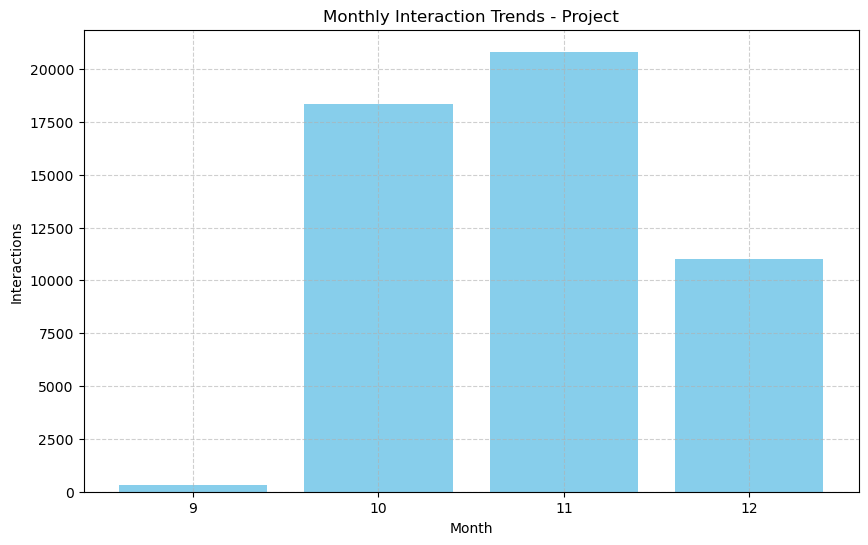

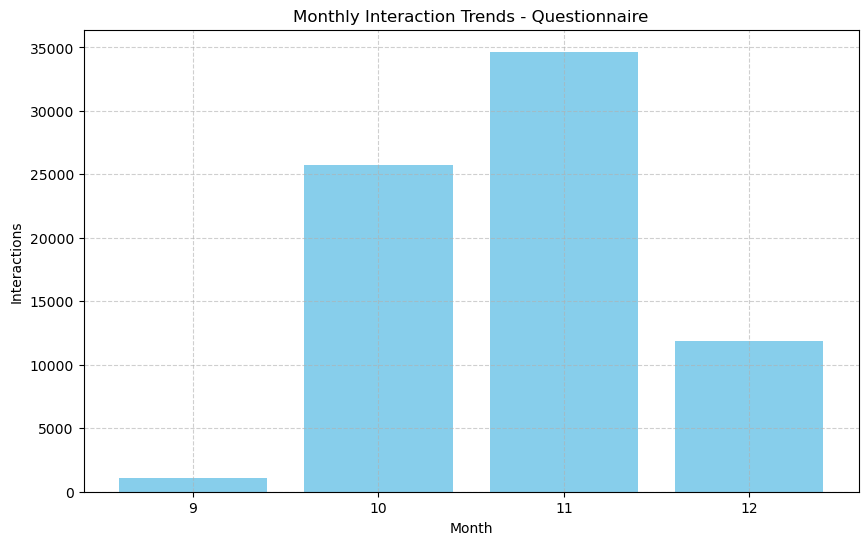

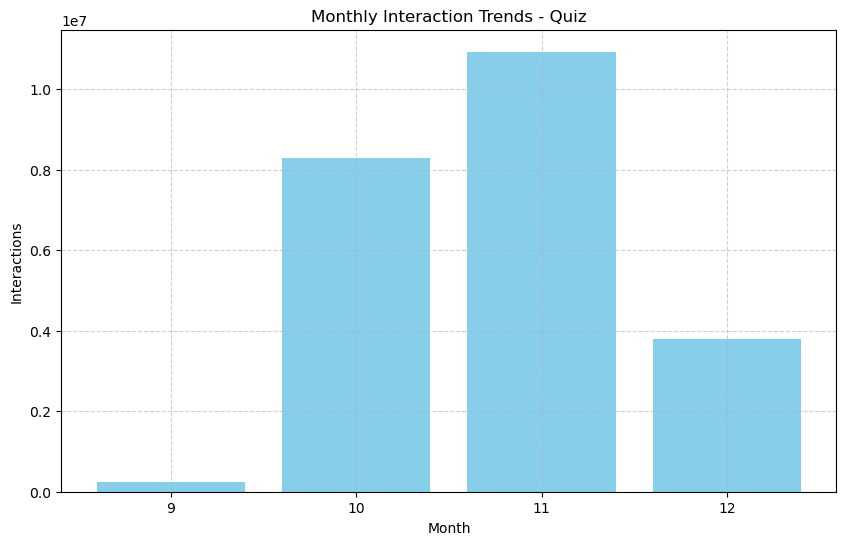

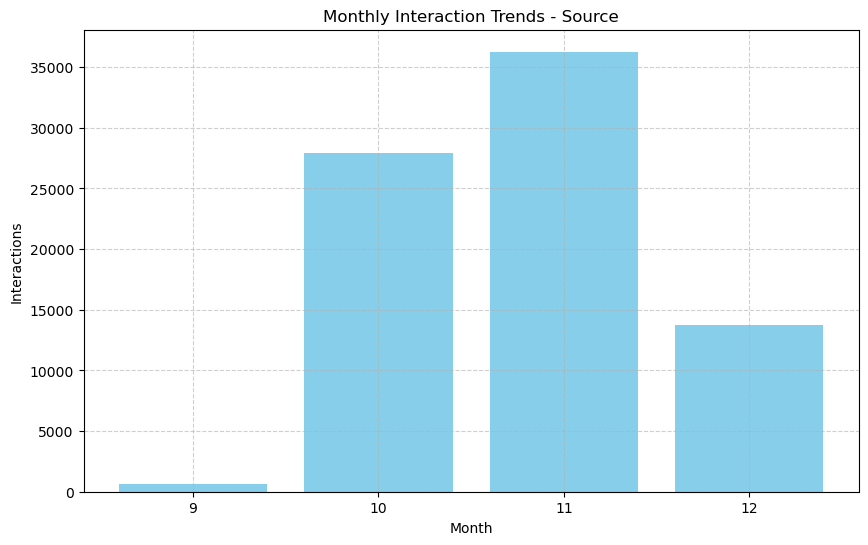

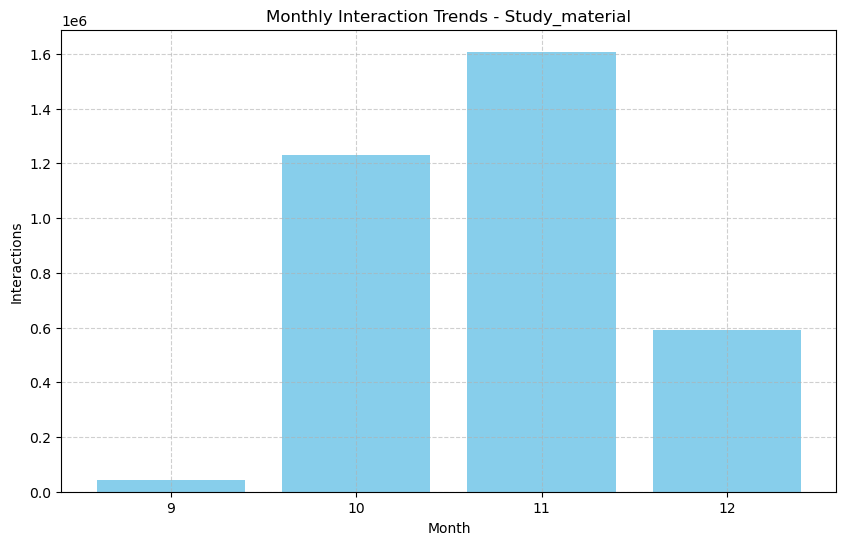

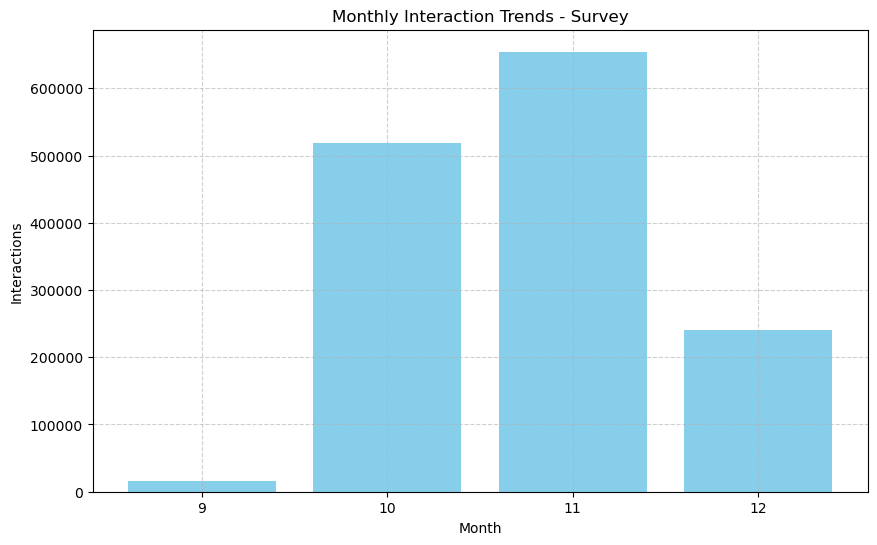

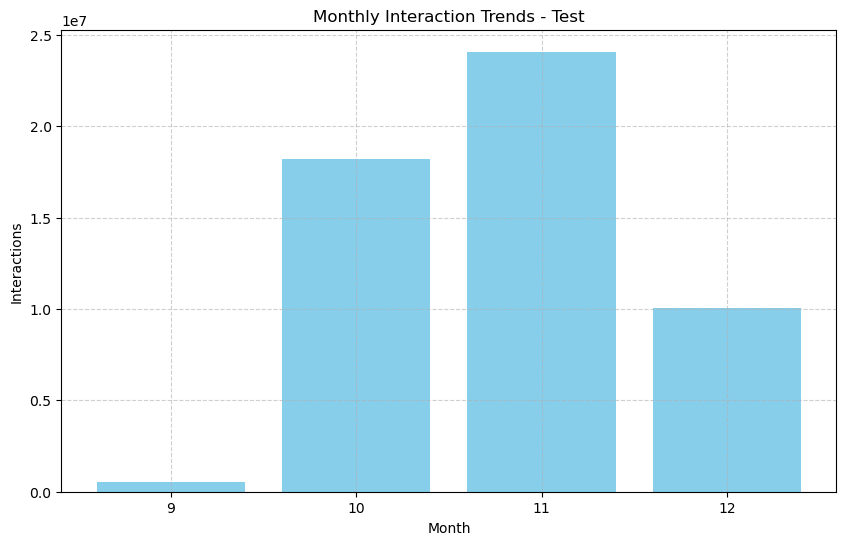

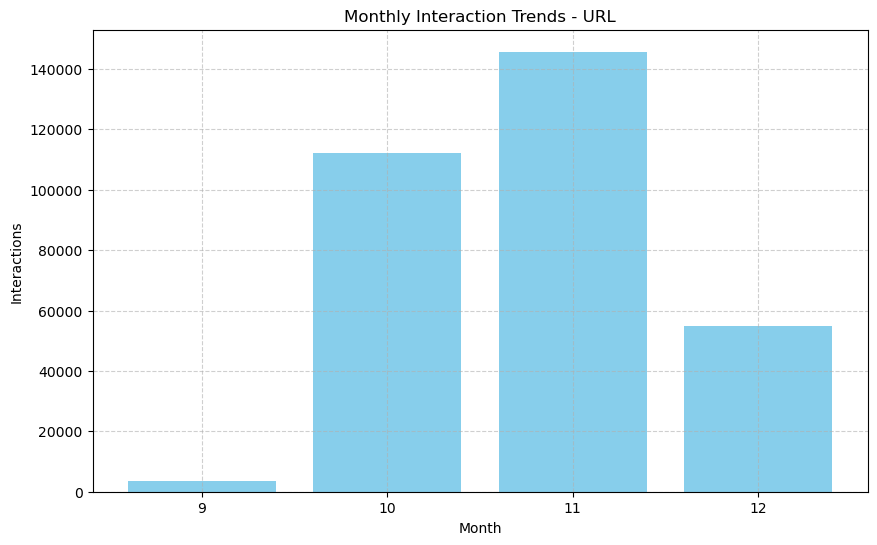

In [ ]:
#------------------------Installation of neccessary libraries ------------------#
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, messagebox, ttk

# ---------------------------- Data Loading and Cleaning ---------------------------- #

def load_csv(file_path):
    """Load CSV file without blocking."""
    try:
        data = pd.read_csv(file_path)
        return data
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load file: {str(e)}")
        return None


def clean_data(user_log, activity_log, component_codes):
    """Clean and prepare data."""
    user_log.dropna(inplace=True)
    activity_log.dropna(inplace=True)
    component_codes.dropna(inplace=True)

    # Remove unwanted components
    activity_log = activity_log.query("Component not in ['System', 'Folder']")

    # Rename columns
    user_log.columns = ['Date', 'Time', 'User_ID']
    activity_log.columns = ['User_ID', 'Component', 'Action', 'Target']

    return user_log, activity_log, component_codes


def merge_and_reshape(user_log, activity_log):
    """Merge logs and reshape data."""
    merged_data = pd.merge(activity_log, user_log, on="User_ID")
    reshaped_data = merged_data.pivot_table(index='User_ID', columns='Component', aggfunc='size', fill_value=0)
    return merged_data, reshaped_data


# ---------------------------- Statistical Analysis ---------------------------- #

def calculate_statistics(data):
    """Calculate mean, median, and mode."""
    stats = data.describe()
    mode = data.mode().iloc[0]
    stats.loc['mode'] = mode
    return stats


def visualize_correlation(data):
    """Visualize correlation as heatmap (non-blocking)."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
    plt.title('Correlation Heatmap')
    plt.draw()  # Non-blocking visualization
    plt.pause(0.001)


def visualize_trends(merged_data):
    """Visualize trends in user interactions split by components (non-blocking)."""
    merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%d/%m/%Y %H:%M', cache=True)
    merged_data['Month'] = merged_data['Date'].dt.month
    interaction_counts = merged_data.groupby(['Month', 'Component']).size().unstack(fill_value=0)

    for component in interaction_counts.columns:
        plt.figure(figsize=(10, 6))
        plt.bar(interaction_counts.index, interaction_counts[component], color='skyblue')
        plt.title(f'Monthly Interaction Trends - {component}')
        plt.xlabel('Month')
        plt.ylabel('Interactions')
        plt.xticks(interaction_counts.index)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.draw()  # Non-blocking visualization
        plt.pause(0.001)


# ---------------------------- Save Data Feature ---------------------------- #

def save_file(data, file_type):
    """Save data to a file."""
    save_path = filedialog.asksaveasfilename(defaultextension=".csv", filetypes=[("CSV files", "*.csv")])
    if save_path:
        try:
            data.to_csv(save_path, index=False)
            messagebox.showinfo("Success", f"{file_type} saved successfully!")
        except Exception as e:
            messagebox.showerror("Error", f"Failed to save {file_type}: {str(e)}")


# ---------------------------- GUI Application ---------------------------- #

def build_gui():
    """Build GUI with asynchronous processing."""
    def process_data_step(step=0):
        """Perform processing step-by-step using after()."""
        global user_log, activity_log, component_codes, merged_data, reshaped_data, stats

        try:
            # Step 1: Load files
            if step == 0:
                progress_bar['value'] = 10
                user_log = load_csv(user_log_file.get())
                activity_log = load_csv(activity_log_file.get())
                component_codes = load_csv(component_codes_file.get())
                root.after(100, process_data_step, step + 1)

            # Step 2: Clean data
            elif step == 1:
                progress_bar['value'] = 30
                user_log, activity_log, component_codes = clean_data(user_log, activity_log, component_codes)
                root.after(100, process_data_step, step + 1)

            # Step 3: Merge and reshape
            elif step == 2:
                progress_bar['value'] = 50
                merged_data, reshaped_data = merge_and_reshape(user_log, activity_log)
                root.after(100, process_data_step, step + 1)

            # Step 4: Analyze data
            elif step == 3:
                progress_bar['value'] = 70
                stats = calculate_statistics(reshaped_data)
                root.after(100, process_data_step, step + 1)

            # Step 5: Visualizations
            elif step == 4:
                visualize_correlation(reshaped_data)
                visualize_trends(merged_data)
                root.after(100, process_data_step, step + 1)

            # Step 6: Save Data Buttons
            elif step == 5:
                tk.Button(root, text="Save Statistics", command=lambda: save_file(stats, "Statistics")).pack(pady=5)
                tk.Button(root, text="Save Reshaped Data", command=lambda: save_file(reshaped_data, "Reshaped Data")).pack(pady=5)
                progress_bar['value'] = 100
                messagebox.showinfo("Success", "Processing Complete!")
        except Exception as e:
            messagebox.showerror("Error", str(e))

    # Graceful exit function
    def on_exit():
        """Cancel tasks and exit gracefully."""
        plt.close('all')  # Close all open plots
        root.destroy()  # Destroy GUI

    # GUI Setup
    root = tk.Tk()
    root.title("Prototype Data Processor")
    root.geometry("600x500")

    tk.Label(root, text="Prototype Application for Data Analysis", font=("Arial", 14)).pack(pady=10)

    tk.Label(root, text="User Log File:").pack()
    user_log_file = tk.Entry(root, width=50)
    user_log_file.pack()
    tk.Button(root, text="Browse", command=lambda: user_log_file.insert(0, filedialog.askopenfilename())).pack()

    tk.Label(root, text="Activity Log File:").pack()
    activity_log_file = tk.Entry(root, width=50)
    activity_log_file.pack()
    tk.Button(root, text="Browse", command=lambda: activity_log_file.insert(0, filedialog.askopenfilename())).pack()

    tk.Label(root, text="Component Codes File:").pack()
    component_codes_file = tk.Entry(root, width=50)
    component_codes_file.pack()
    tk.Button(root, text="Browse", command=lambda: component_codes_file.insert(0, filedialog.askopenfilename())).pack()

    progress_bar = ttk.Progressbar(root, orient="horizontal", length=400, mode="determinate")
    progress_bar.pack(pady=10)

    tk.Button(root, text="Process and Analyze Data", command=lambda: process_data_step()).pack(pady=20)
    tk.Button(root, text="Exit", command=on_exit).pack()

    root.mainloop()


# ---------------------------- Main Execution ---------------------------- #

if __name__ == "__main__":
    build_gui()
